In [ ]:
!pip install twython
!pip install vaderSentiment
!pip install colorama

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, init
import plotly.express as px
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
import pandas as pd
df = pd.read_csv('/content/sentimentdataset.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [ ]:
df = df.dropna(axis=0, how='any')
df = df.dropna(axis=1, how='any')
df = df.drop_duplicates()

In [ ]:
print(df.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')


In [ ]:
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Hashtags','Day', 'Hour','Sentiment'])

In [ ]:
df['Platform'] = df['Platform'].str.strip()
df['Country'] = df['Country'].str.strip()
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Day_of_Week'] = df['Timestamp'].dt.day_name()

In [ ]:
month_mapping = {
    1: 'Januari',
    2: 'Februari',
    3: 'Maret',
    4: 'April',
    5: 'Mei',
    6: 'Juni',
    7: 'Juli',
    8: 'Agustus',
    9: 'September',
    10: 'Oktober',
    11: 'November',
    12: 'Desember'
}

df['Month'] = df['Month'].map(month_mapping)

df['Month'] = df['Month'].astype('object')

In [ ]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = " ".join(text.split())
    tokens = word_tokenize(text)

    cleaned_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]

    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

df["Clean_Text"] = df["Text"].apply(clean)

In [ ]:
df1 = df.copy()
analyzer = SentimentIntensityAnalyzer()

df1['Vader_Score'] = df1['Clean_Text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df1['Sentiment'] = df1['Vader_Score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

print(df1[['Clean_Text', 'Vader_Score', 'Sentiment']].head())

                     Clean_Text  Vader_Score Sentiment
0         enjoy beauti day park       0.4939  positive
1          traffic terribl morn       0.0000   neutral
2           finish amaz workout       0.0000   neutral
3   excit upcom weekend getaway       0.0000   neutral
4  tri new recip dinner tonight       0.0000   neutral


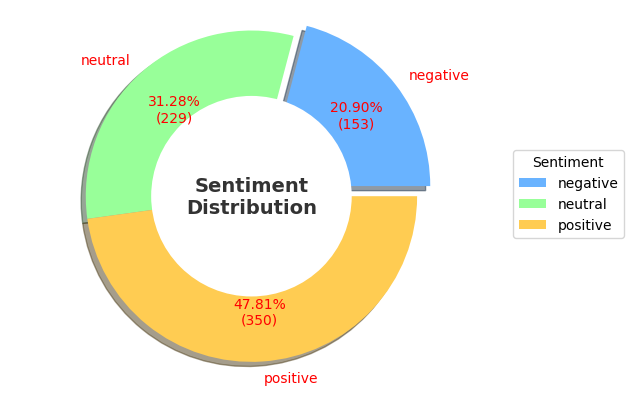

In [ ]:
colors = ['#69b3ff', '#98ff99', '#ffcc52']

explode = (0.1, 0, 0)

sentiment_counts = df1.groupby("Sentiment").size()

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts,
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})',
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True)
center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')

plt.show()

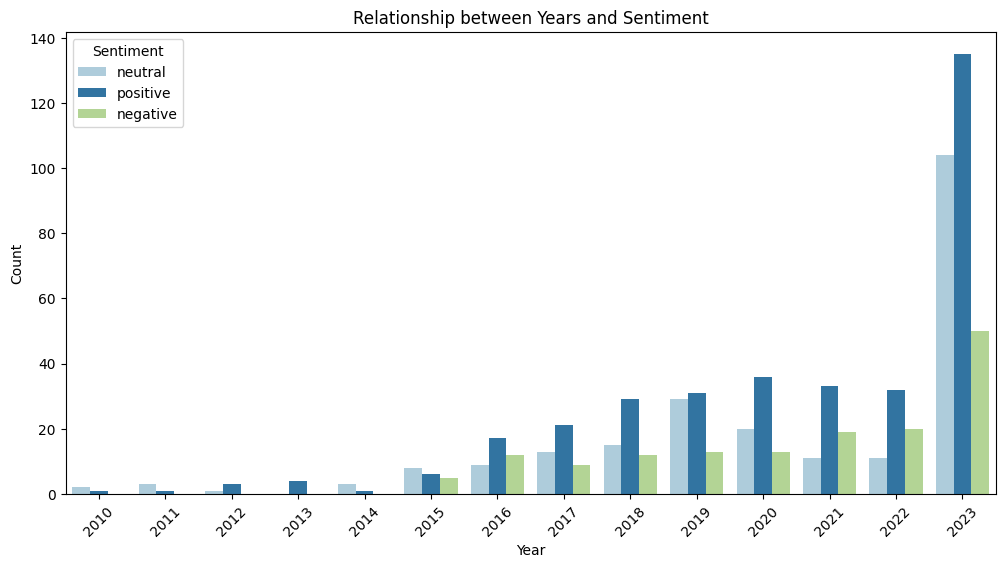

In [52]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Years and Sentiment')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

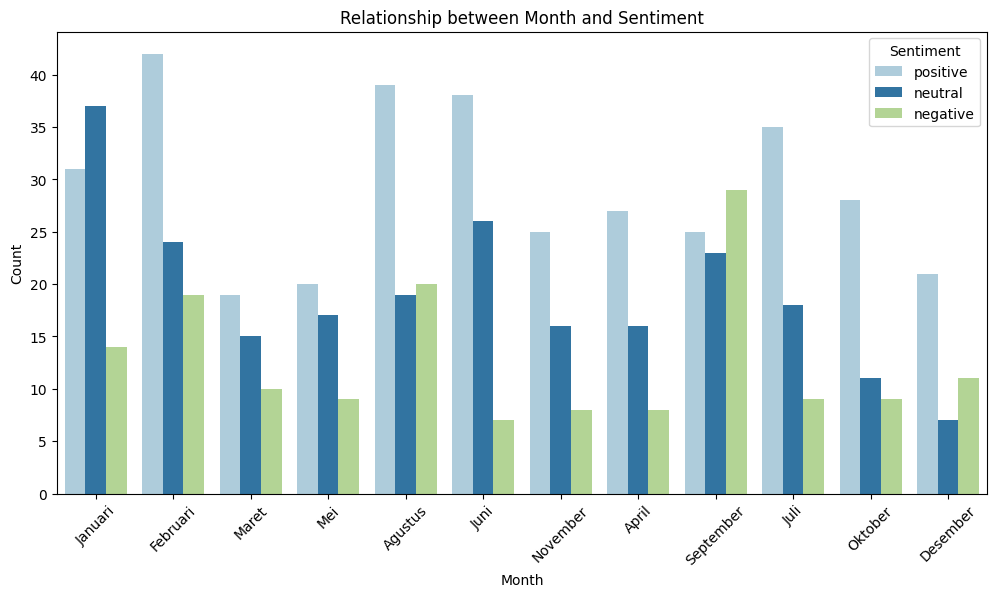

In [53]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Month and Sentiment')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

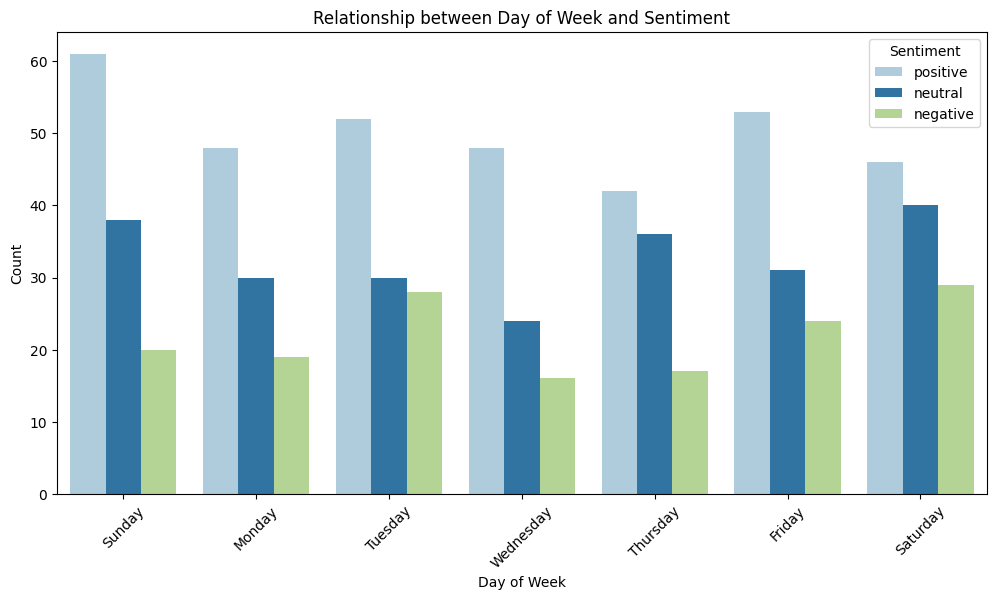

In [54]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Day_of_Week', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Day of Week and Sentiment')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

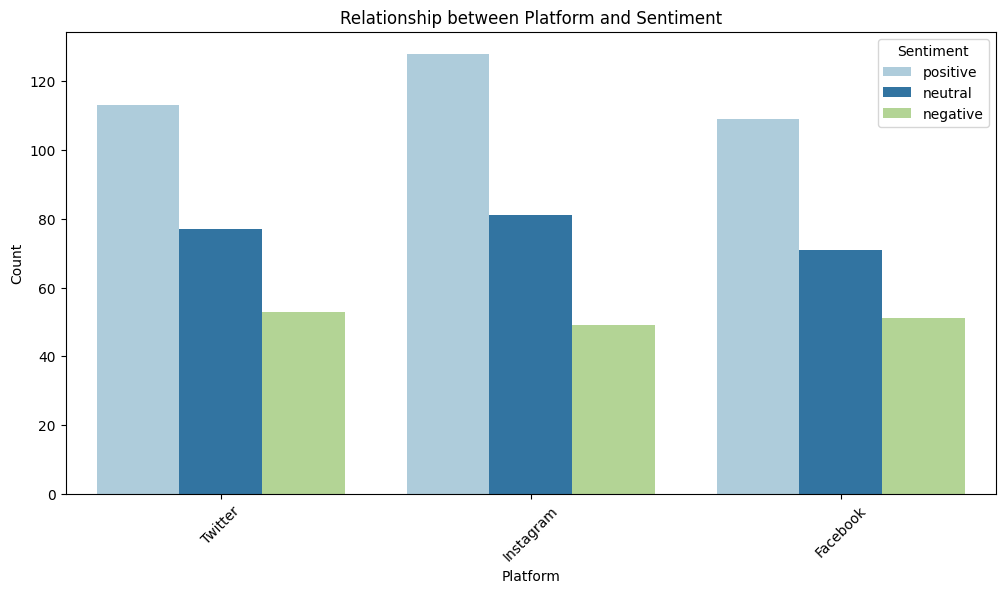

In [55]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Platform', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Platform and Sentiment')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

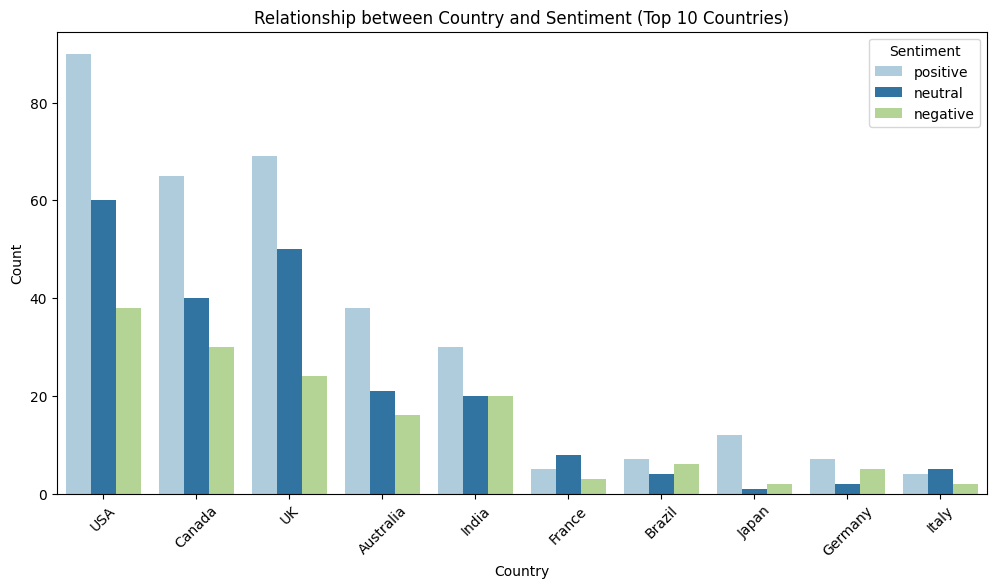

In [56]:
plt.figure(figsize=(12, 6))

top_10_countries = df1['Country'].value_counts().head(10).index

df_top_10_countries = df1[df1['Country'].isin(top_10_countries)]

sns.countplot(x='Country', hue='Sentiment', data=df_top_10_countries, palette='Paired')
plt.title('Relationship between Country and Sentiment (Top 10 Countries)')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [58]:
#common word
df1['temp_list'] = df1['Clean_Text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

fig = px.bar(top_words_df,
            x="count",
            y="Common_words",
            title='Common Words in Text Data',
            orientation='h',
            width=700,
            height=700,
            color='Common_words')

fig.show()

In [59]:
Positive_sent = df1[df1['Sentiment'] == 'positive']
Negative_sent = df1[df1['Sentiment'] == 'negative']
Neutral_sent = df1[df1['Sentiment'] == 'neutral']

In [60]:
#positive word
top = Counter([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,joy,30
1,friend,24
2,laughter,24
3,new,21
4,challeng,20
5,life,20
6,hope,20
7,dream,20
8,embrac,19
9,like,19


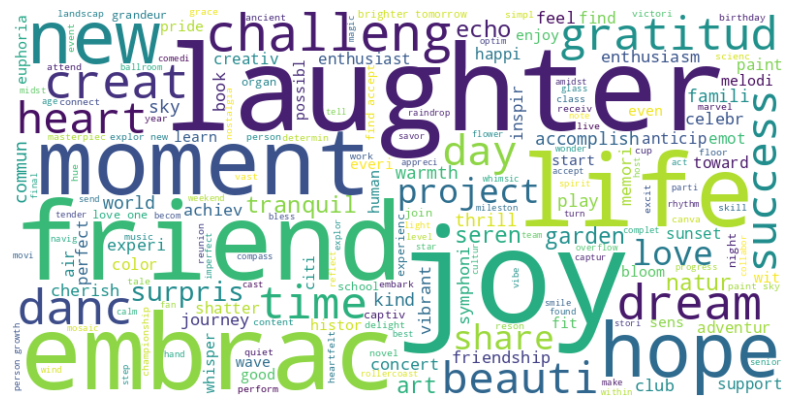

In [63]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [61]:
#neutral word
top = Counter([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Blues')

,Common_words,count
0,new,22
1,explor,13
2,excit,12
3,life,12
4,beauti,12
5,night,12
6,danc,12
7,attend,11
8,seren,11
9,feel,10


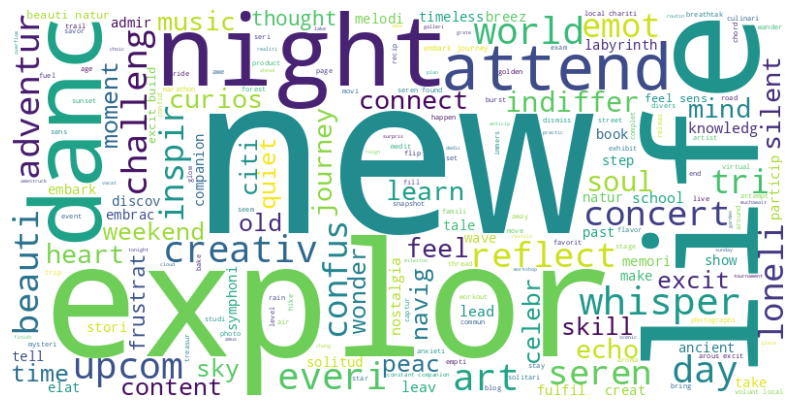

In [64]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [62]:
#negative word
top = Counter([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Reds')

,Common_words,count
0,despair,14
1,lost,14
2,emot,13
3,feel,11
4,bitter,10
5,storm,10
6,day,9
7,like,9
8,grief,8
9,heart,8


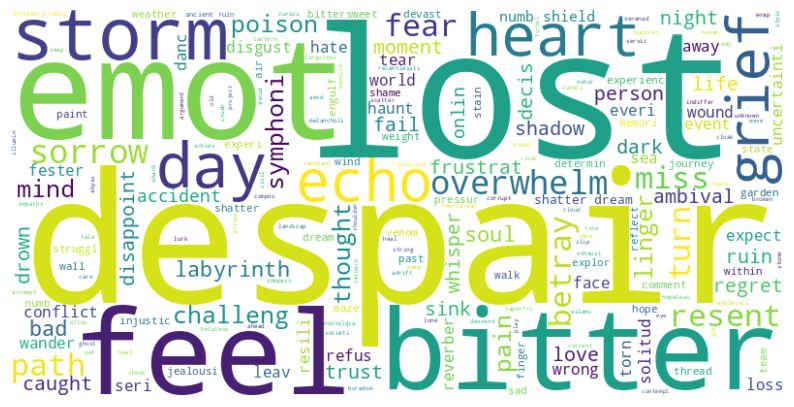

In [65]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()